# Pipeline test with RCA FISH

**How Version 5 differs from previous versions:** V5 test images are filtered without oversaturation.

- Inputs:
    - 1 RCA FISH sample image
    - expert annotations of the sample image
    - 3 RCA FISH test images
- Operations: 
    - **Part 1**: parameter extraction from sample image
    - **Part 2**: blob detection on test images, using parameter extraction
    - **Part 3**: cropping of test images, using parameter extraction
    - **Part 4**: QC and reassembly of turker-annotated crops
    - **Part 5**: evaluation of precision and recall
- Outputs:
    - Consensus turker annotation coordinates
    - Precision and recall analysis
    
# Old stuff: 

## Takeaway: From V1 to V2, recall has increased and precision has decreased.

#### Turker consensus annotation results:
(agreement between worker consensus and “expert”)

|Image|Precision v1|Recall v1|Precision v2|Recall v2|
|------|------|------|------|------|
|ISS_rnd0_ch1_z0	|0.750902		|0.345825	|0.496361	|0.527864
|ISS_rnd0_ch3_z0	|0.655556		|0.471173		|0.494444	|0.529940
|ISS_rnd1_ch1_z0	|0.632743		|0.414493	|0.513274		|0.630435

To see this in the notebook visualized as scatter plots, command + F `Visualize precision and recall.`
To see this in the notebook visualized as scatter plots and with reference points plotted, command + F `Visualize precision and recall, showing reference points`

#### While precision has decreased from v1 to v2, recall has increased and is now better than the baseline recall of blob_log() spot detection, except for the first test image (ISS_rnd0_ch1_z0). Note that when looking at the Jenny's annotations for ISS_rnd0_ch1_z0, Kevin had noted that there were some more spots he would have clicked.

Compare with blob_log()’s performance:

#### blob_log() spot detection results:
(agreement between blob_log() and “expert”)

|Image			|Precision	|Recall
|------|------|------|
|ISS_rnd0_ch1_z0	|0.930178		|0.532544
|ISS_rnd0_ch3_z0	|0.944223		|0.471173
|ISS_rnd1_ch1_z0	|0.956250		|0.443478

To see this in the notebook visualized as plots, command + F `Plot Correct vs. Incorrect, Detected vs. Undetected`

It seems that “poor” turker performance might still be a result of mismatch between "expert" and turker opinions about what a spot should look like. blob_log() learns directly from lots of expert-annotated examples about what a spot should look like and then “plays it safe,” detecting only spots which the “expert” would probably detect but missing a lot of less-obvious spots which the “expert” would probably detect, and therefore ending up with higher precision. The turkers, on the other hand, take more risks and end up with higher recall but lower precision.

**Note:** the turker annotations for round 1 and round 2 are both the same, so the turkers didn’t get better instructions for round 2.

In [1]:
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
sys.path.insert(0, '../../../FISH-annotation/Annotation')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

%load_ext autoreload
%autoreload 2

## User Inputs

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4
max_num_crops = 7
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3

In [3]:
sample_img_filename = 'ISS_rnd0_ch0_z0.png'
sample_img_path = './sample_image_filtered/' + sample_img_filename
sample_coords_filename = 'ISS_rnd0_ch0_z0.csv'
sample_coords_path = './sample_image_filtered/' + sample_coords_filename

In [4]:
test_img_filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']
test_img_paths = ['./test_images_filtered/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = ['./test_images_filtered/coords/%s.csv' % x for x in test_img_filenames]

# Part 1: Parameter Extraction

### This section of the pipeline:

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Outputs: 
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
    - these parameters are saved in ./sample_image_filtered/spot_params

### View sample image

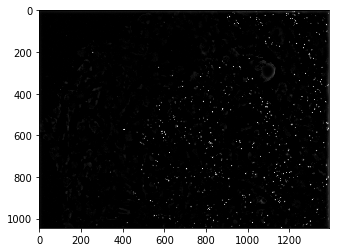

In [48]:
im = imread(sample_img_path, as_gray=True)
plt.imshow(im, cmap='gray')
plt.show()

# Find limits on spot size

### Find the size of each spot identified by the expert and take the max and min

In [16]:
ref_coords = np.genfromtxt(sample_coords_path, delimiter=',')[1:]
min_sigma, max_sigma = util.get_sigma_limits(sample_img_path, ref_coords, margin)

# Find the optimal intensity threshold

### Assign a range of intensity thresholds to test.

In [20]:
thresholds = np.arange(0.1, 0.4, 0.03)

### Run blob detection with a range of thresholds and evaluate precision and recall overall.

In [28]:
best_threshold, best_recall, best_precision, recall_list, precision_list = util.get_best_threshold(sample_coords_path, sample_img_path, min_sigma, max_sigma, ref_coords, correctness_threshold, thresholds)


../../../FISH-annotation/Annotation/util.py:186: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()


Threshold = 0.100000
Threshold = 0.130000
Threshold = 0.160000
Threshold = 0.190000
Threshold = 0.220000
Threshold = 0.250000
Threshold = 0.280000
Threshold = 0.310000
Threshold = 0.340000
Threshold = 0.370000
Threshold = 0.400000


Text(0.5,1,'Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

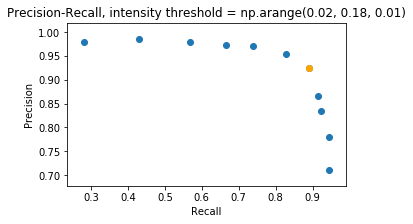

In [29]:
plt.figure(figsize = (5, 3))
plt.scatter(recall_list, precision_list)
plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

## Print and save blob detection parameters
The min sigma, max sigma, and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [30]:
print('greatest spot_sigma = %f' % (round(max_sigma, 2)))
print('smallest spot_sigma = %f' % (round(min_sigma, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))
if not os.path.exists('./sample_image_filtered/spot_params/'):
    os.mkdir('./sample_image_filtered/spot_params/')
np.savetxt('./sample_image_filtered/spot_params/' + sample_coords_filename, [[min_sigma, max_sigma, best_threshold]], header='min_sigma,max_sigma,best_threshold', delimiter=",", comments='')

greatest spot_sigma = 10.030000
smallest spot_sigma = 0.670000
optimal intensity threshold = 0.220000


# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `max_sigma`
        - min sigma: `min_sigma`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection

### Run blob_log() on all test images using min_sigma, max_sigma, and best_threshold found above.

In [32]:
blob_params = pd.read_csv('./sample_image_filtered/spot_params/' + sample_coords_filename)
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]

for img_path, coords_path in zip(test_img_paths, test_coords_paths):

    im = imread(img_path, as_gray=True)
    img_height = len(im)
    
    if not os.path.exists('./test_images_filtered/blobs/'):
        os.mkdir('./test_images_filtered/blobs/')
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    
    blobs_log = blob_log(im, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, sigma in blobs_log]
    
    np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

### Plot Detected Blobs

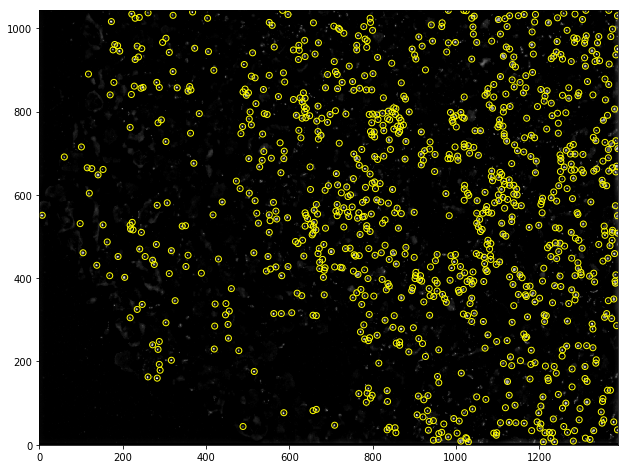

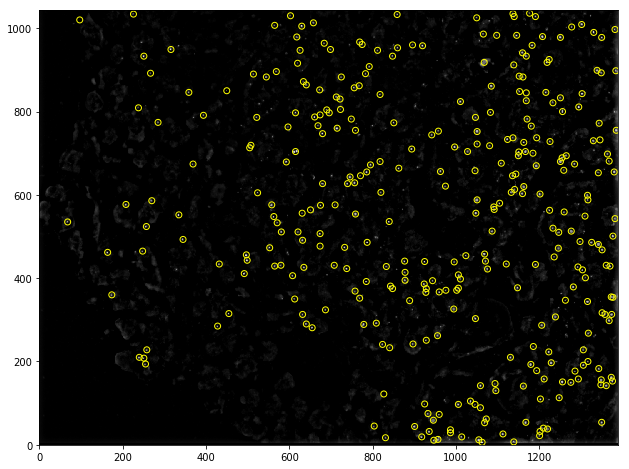

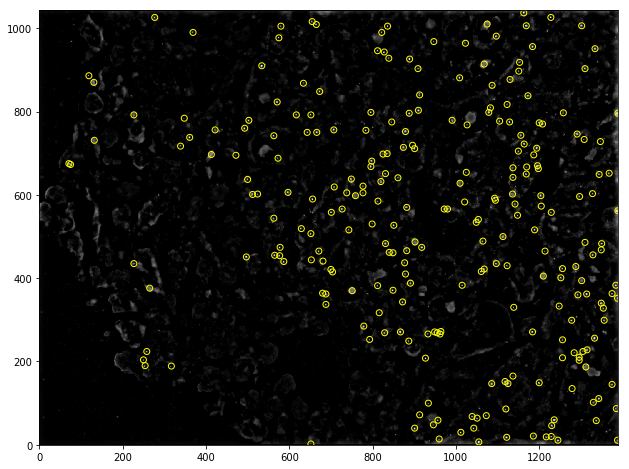

In [36]:
for img_path in test_img_paths:
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))
    
    plt.figure(figsize=(12, 8))
    im = imread(img_path)
    plt.imshow(im, cmap='gray')
    for x, y in blobs:
        plt.scatter([x], [y], facecolors='None', edgecolors='yellow')
    plt.xlim(0, im.shape[1])
    plt.ylim(0, im.shape[0])
    plt.show()

# Part 3: Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection
- Outputs:
    - crops ready to be sent to mechanical turkers

In [46]:
if not os.path.exists('./test_images_filtered/crops/'):
    os.mkdir('./test_images_filtered/crops/')
    
for img_path, img_name in zip(test_img_paths, test_img_filenames):
    
    crops_path = './test_images_filtered/crops/%s/' % img_name
    
    if not os.path.exists(crops_path):
        os.mkdir(crops_path)
    
    blob_path = img_path.replace('images/', 'blobs/').replace('.png', '.csv')
    blobs = np.asarray(pd.read_csv(blob_path))

    image_width = imread(img_path).shape[1]
    crosshair_arm_length = crosshair_ratio * image_width
    
    util.autocrop(blobs, img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio)
    